In [2]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
import pandas as pd

from pyspark import SparkContext, SparkConf
from pyspark.rdd import RDD
from pyspark.sql import Row
from pyspark.sql import SparkSession
from pyspark.sql.functions import pandas_udf, col

from utils import compute_centroidDistances, get_clusterId, get_minDistance

In [3]:
# build a SparkSession 
#   connect to the master node on the port where the master node is listening (7077)
#   declare the app name 
#   configure the executor memory to 512 MB
#   either *connect* or *create* a new Spark Context
spark = SparkSession.builder \
    .master("spark://spark-master:7077")\
    .appName("kMeansParallel")\
    .config("spark.executor.memory", "512m")\
    .getOrCreate()

sc = spark.sparkContext
sc.addPyFile("utils.py")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/09/02 13:11:42 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


### Naming conventions

The single datum is named as `datumName`, while the RDD that is a collection of one or more data is called `datumName_rdd`.

Example: `compute_clusterDistances` returns `clusterDistances` (i.e. a numpy array of distances between a point `x` and the `centroids`). 
The RDD that collects all the `clusterDistances` will be called `clusterDistances_rdd`, and here is a sample implementation of that:
```python
def compute_centroidDistances(x, centroids):
    return np.sum((centroids - x)**2, axis = 1)

# `data_rdd` is an RDD
# `centroids` is a numpy array
clusterDistances_rdd = data_rdd \
    .map(lambda x: compute_clusterDistances(x, centroids))
```

In [4]:
#CREATE A TOY DATASET FOR TESTING

# Parameters for toy dataset
num_points_per_cluster = 50
num_clusters = 10
dim = 2  # 2D points for easy visualization
spread = 0.5
seed = 42
np.random.seed(seed)

centers = np.random.uniform(-10, 10, (num_clusters, dim))
data = np.concatenate(
    [center + spread * np.random.randn(num_points_per_cluster, dim) for center in centers],
    axis = 0
)
data_rdd = sc.parallelize(
    [row for row in data],
    numSlices = 3
)

data_rdd = data_rdd.persist()

In [5]:
def kMeansPlusPlus_init(
    data: npt.NDArray,
    k: int,
    weights: npt.NDArray = np.array([])
) -> npt.NDArray:
    if weights.shape[0] == 0:
        weights = np.ones(shape=(data.shape[0],1))
    
    centroids = data[np.random.randint(0, data.shape[0]),:].reshape(1, -1) # reshaping for easier stacking
    
    while (centroids.shape[0] < k):
        minDistance_array = np.array([get_minDistance(compute_centroidDistances(datum, centroids)) for datum in data]) * weights
        total_minDistance = np.sum(minDistance_array)
        # sampling probability proportional to minDistance
        new_centroid_idx = np.random.choice(minDistance_array.shape[0], size = 1, p = minDistance_array / total_minDistance)
        new_centroid = data[new_centroid_idx,:].reshape(1, -1)

        # edge case in which the same centroid is selected twice:
        # redo the iteration without saving the centroid
        if any(np.array_equal(new_centroid, row) for row in centroids): continue
        centroids = np.concatenate((centroids, new_centroid), axis = 0)

    return centroids

In [6]:
def kMeansNaive(
    data: npt.NDArray,
    centroids: npt.NDArray,
    epochs: int = 5
) -> npt.NDArray:
    k = centroids.shape[0]
    for _ in range(epochs):
        assignments = np.array(
            [get_clusterId(compute_centroidDistances(x, centroids)) for x in data]
        )
        centroids = np.array(
            [np.mean(data[assignments==i,:], axis = 0) for i in range(k)]
        )
    return centroids

In [12]:
def kMeansParallel_init(
    data_rdd: RDD,
    k: int,
    l: float
) -> npt.NDArray:

    centroids = np.array(
        data_rdd.takeSample(num=1, withReplacement=False)
    )
    
    minDistance_rdd = data_rdd \
        .map(lambda x: (x, get_minDistance(compute_centroidDistances(x, centroids)))) \
        .persist()

    cost = minDistance_rdd \
        .map(lambda x: x[1]) \
        .sum()

    iterations = int(np.ceil(np.log(cost))) if (cost > 1) else 1
    for _ in range(iterations):
        new_centroids = np.array(
            minDistance_rdd \
                .filter(lambda x: np.random.rand() < np.min((l * x[1] / cost, 1))) \
                .map(lambda x: x[0]) \
                .collect()
        )
        # edge case in which no new centroid is sampled:
        # this avoids the following `np.concatenate` to fail
        if len(new_centroids.shape) < 2:
            continue

        minDistance_rdd.unpersist()
        centroids = np.unique(
            np.concatenate((centroids, new_centroids), axis = 0), 
            axis = 0
        )

        minDistance_rdd = data_rdd \
            .map(lambda x: (x, get_minDistance(compute_centroidDistances(x, centroids)))) \
            .persist()
        cost = minDistance_rdd \
            .map(lambda x: x[1]) \
            .sum()
    
    minDistance_rdd.unpersist()
    clusterCounts = data_rdd \
        .map(lambda x: (get_clusterId(compute_centroidDistances(x, centroids)), 1)) \
        .countByKey()
    
    clusterCounts = np.array([w[1] for w in clusterCounts.items()])
    centroids = kMeansNaive(
        centroids, 
        kMeansPlusPlus_init(centroids, k, clusterCounts)
    )
    
    return centroids

In [13]:
k = num_clusters
l = k * 10
centroids = kMeansParallel_init(data_rdd, k, l)

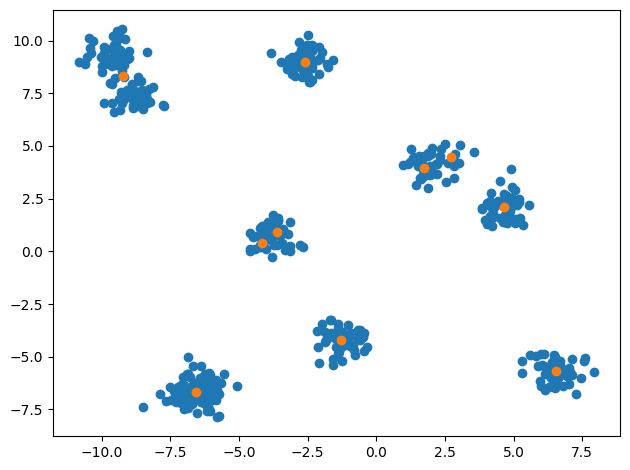

In [14]:
data = np.array(data)
centroids = np.array(centroids)
fig, ax = plt.subplots()
ax.scatter(data[:,0], data[:,1])
ax.scatter(centroids[:,0], centroids[:,1])
fig.tight_layout()

In [15]:
sc.stop()
spark.stop()